# Music21 Scale Tables

In this notebook we are developing a eye-candy presentation of scale data generated by music21 and our music21 toolchain.

## Web of Reference

### Music / Sheet Music

* [music21](http://web.mit.edu/music21/doc/moduleReference/index.html) **THIS ^**
* [abcjs](https://github.com/paulrosen/abcjs)

### Tables

* SVG
  * [svgwrite](http://pythonhosted.org/svgwrite/) **WIN!!**
  * [plim](https://plim.readthedocs.io/en/latest/syntax.html)
* [pandas]() / [style](http://pandas.pydata.org/pandas-docs/version/0.18.1/style.html)
* [d3.js](https://d3js.org/)

### Colors

* matplotlib
  * [Pyplot colormap line by line – StackOverflow](http://stackoverflow.com/questions/27443050/pyplot-colormap-line-by-line)
  * [Choosing Colormaps – Matplotlib](http://matplotlib.org/users/colormaps.html)
  * [cm (colormap)](http://matplotlib.org/api/cm_api.html)
  * [colors – Matplotlib](http://matplotlib.org/api/colors_api.html)
* [colormap (pypi)](https://pypi.python.org/pypi/colormap)
* [palettable](https://jiffyclub.github.io/palettable) / [source](https://github.com/jiffyclub/palettable)
* [pallete (pypi)](https://pypi.python.org/pypi/palette)
* [colour (pypi)](https://pypi.python.org/pypi/colour)
* [Solarized Color Scheme](http://ethanschoonover.com/solarized)
* [Seaborn](http://chrisalbon.com/python/seaborn_color_palettes.html) **Very probably..**
* [Colour Science](http://colour-science.org/)
* Hardcode? **Very probably**

### Audio

* [Tone.js](https://github.com/Tonejs/Tone.js) **Very Probably..**
* [MIDI.js](https://github.com/mudcube/MIDI.js)

### Persistency

* sqlite3
* [sqlalchemy](http://docs.sqlalchemy.org/en/rel_1_1/)

### etc

* [Jupyter Magics](https://ipython.org/ipython-doc/3/interactive/magics.html)

In [2]:
from music21 import *
from IPython.display import display, HTML #, Image, Audio
#import plim
import base64
#from music21.common.pathTools import relativepath as m21_jupyter_relpath
from PIL import Image as PILImage
import svgwrite as sw
import seaborn

In [3]:
def circleOfFifths():
    fifths = []

    fifthsScale = scale.CyclicalScale('c4', 'p5')
    
    for p in fifthsScale.getPitches('c4', 'c11'):
        
        if key.pitchToSharps(p,'major') <= 7:
            MAJOR = str(p.simplifyEnharmonic().name)
            MINOR = str(key.Key(MAJOR, 'major').relative.tonic.simplifyEnharmonic().name).lower()

        else:
            MAJOR = str(p.getEnharmonic().simplifyEnharmonic().name)
            MINOR = str(key.Key(MAJOR, 'major').relative.tonic.simplifyEnharmonic().name).lower()
        
        fifths.append( [ MAJOR, MINOR ] )

        #fifths.append(p.simplifyEnharmonic())
        
    return fifths

## The returnScale() function

This function returns a `dict()` with the data and filename of our generated scale.

In [4]:
def returnScale(tonic='c', mode='major', ownKey=False):
    
    modes = [ 'ionian','dorian','phrygian',
              'lydian','mixolydian','aeolian',
              'locrian','major','minor']
    
    if not mode in modes: mode = 'major'
        
    if mode == 'ionian': mode = 'major'
    if mode == 'aeolian': mode = 'minor'

    tonic_pitch = pitch.Pitch(tonic)
    scale_sharps = key.pitchToSharps(tonic_pitch, mode)

    scale_func = getattr(scale, "{0}Scale".format(mode.capitalize()))
    real_scale = scale_func(tonic_pitch)
    pitches = real_scale.getPitches()

    scale_name = real_scale.name
    absolute_intervals = []
    relative_intervals = []
    note_names = []
    myKeySig = key.KeySignature(scale_sharps)
    
    mystream = stream.Stream()
    
    if ownKey:
        mystream.append(myKeySig)

    for idx,cur_pitch in enumerate(pitches):
        mynote = note.Note(cur_pitch)

        cur_degree = real_scale.getScaleDegreeFromPitch(cur_pitch)
        past_degree_or_tonic = cur_degree-1 if cur_degree>1 else 1
        
        absolute_interval = real_scale.intervalBetweenDegrees(1,cur_degree).name
        #relative_interval_semitones = real_scale.intervalBetweenDegrees(past_degree_or_tonic, cur_degree).semitones
        try:
            relative_interval_semitones = interval.notesToChromatic(cur_pitch, pitches[idx+1]).semitones
        except:
            #pass
            relative_interval_semitones = 'None'
        #relative_interval = real_scale.intervalBetweenDegrees(past_degree_or_tonic, cur_degree).name
        
        absolute_intervals.append(absolute_interval)
        relative_intervals.append(relative_interval_semitones)
        note_names.append(cur_pitch.unicodeName)
        #mynote.addLyric(absolute_interval)
        #mynote.addLyric(relative_interval_semitones)
        
        mystream.append(mynote)
        
    filename = mystream.write()
        
    return {
        'scalename': scale_name,
        'stream' : mystream,
        'filename': filename,
        'ai' : absolute_intervals,
        'ri' : relative_intervals,
        'nn' : note_names,
    }

In [5]:
def svg_table2(sc):

    img_w, img_h = PILImage.open(sc['filename']).size

    with open(sc['filename'],'rb') as image_file:
        b64_scale = base64.b64encode(image_file.read()).decode('utf8')
        image_data = "data:image/png;base64,{}".format(b64_scale)

    def y_by_line(line_num, line_height):
        return (line_num-1) * line_height

    svg_attrs = {
        'font-family': 'Inconsolata, monospace',
    #    'shape-rendering':'optimizeQuality',

    }

    title_text_attrs = {
        'fill':'#fff',
        'alignment-baseline' : 'middle',
        'text-anchor' : 'middle',
        'font-weight' : 'bold',
    }

    image_attrs = {
        'stroke' : '#666',
    }
    img_rect_attrs = {
        'fill':'none',
        'stroke':'#000',
        'stroke-width':'1',
    }

    background_attrs = {
        'stroke':'#000',
        'fill':'#fff',
        'stroke-width':'1',
    }

    title_attrs = {
        'color': '#fff',
        'fill':'#336',
        'stroke':'#000',
        'stroke-width':'1',
    }

    cell_rect_attrs = {
        'fill':'#fff',
        'stroke':'#666',
        'stroke-width':'1',
    }
    cell_path_attrs = {
        'fill':'none',
        'stroke':'#000',
        'stroke-width':'1',
    }
    cell_text_attrs = {
        #'fill':'#fff',
        #'stroke':'#333',
        #'stroke-width':'1',
        'alignment-baseline' : 'middle',
        'text-anchor' : 'middle',
        'font-weight' : 'bold',
    }
    # sizes in px

    #line_height = 32

    #table_width = 440
    table_width = img_w
    line_height = img_h/3

    table_height = line_height*7

    cell_width = table_width/8

    # SVG

    dwg = sw.Drawing(profile='full', size=("{}".format(table_width),"{}".format(table_height)), **svg_attrs)

    # BACKGROUND

    # why not beutiful background right now;
    background = sw.shapes.Rect(insert=(0,0), size=(table_width, table_height), **background_attrs)
    dwg.add(background)

    # TITLE
    
    cell_group = sw.container.Group()

    group_els = [
        sw.shapes.Rect(insert=(0,0), size=(table_width, line_height), **title_attrs),
        sw.text.Text(sc['scalename'], insert=(table_width/2, line_height/2), **title_text_attrs)
    ]

    for element in group_els:
        cell_group.add(element)

    dwg.add(cell_group)

    # IMAGE

    table_image = sw.image.Image(href=image_data, insert=(0,line_height), size=(img_w, img_h))
    dwg.add(table_image)
    #array = [1,2,3,4,5,6,7,8]
    #array2 = ["I","II","III","IV","V","VI","VII","VIII"]
    cell_group = sw.container.Group()

    group_els = [
        sw.image.Image(href=image_data, insert=(0,line_height), size=(img_w, img_h)),
        sw.shapes.Rect(insert=(0,line_height), size=(img_w, img_h), **img_rect_attrs),
    ]

    for element in group_els:
        cell_group.add(element)

    dwg.add(cell_group)
    
    # ABSOLUTE

    for idx,item in enumerate(sc['ai']):

        x = idx * cell_width
        y = y_by_line(line_num=5, line_height=line_height)

        v_center = (line_height/2) + y
        h_center = (cell_width/2) + x

        cell_group = sw.container.Group()

        group_els = [
            sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
            sw.text.Text(item, insert=(h_center, v_center), **cell_text_attrs)
        ]

        for element in group_els:
            cell_group.add(element)

        dwg.add(cell_group)

    # NOTE NAMES
    for idx,item in enumerate(sc['nn']):

        x = idx * cell_width
        y = y_by_line(line_num=6, line_height=line_height)

        v_center = (line_height/2) + y
        h_center = (cell_width/2) + x

        cell_group = sw.container.Group()

        group_els = [
            sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
            sw.text.Text(item, insert=(h_center, v_center), **cell_text_attrs)
        ]

        for element in group_els:
            cell_group.add(element)

        dwg.add(cell_group)
        
    # INTERVALS
    for idx,item in enumerate(sc['ri']):
        v_center = (line_height/2) + idx * y_by_line(line_num=7, line_height=line_height)
        h_center = (cell_width/2) + y_by_line(line_num=7, line_height=line_height)

        x = idx * cell_width + (cell_width/2)
        y = y_by_line(line_num=7, line_height=line_height) + (line_height/2)
        
        path_h_pad = cell_width /10
        path_width = cell_width - path_h_pad
        path_height = (line_height/3)
        path_v_pad = -(path_height/2)
        cell_group = sw.container.Group()
        
        # minor second
        if item == 1:
            path_commands = [
                'M{0} {1}'.format(x,y-path_height/2),
                'l {0} {1}'.format(path_width/2, path_height),
                'l {0} -{1}'.format(path_width/2, path_height),
            ]


        # major second
        elif item == 2:
            path_commands = [
                'M{0} {1}'.format(x,y-path_height/2),
                'v {0}'.format(path_height),
                'h {0}'.format(path_width),
                'v -{0}'.format(path_height),
            ]
            
        group_els = [
            sw.path.Path(d=path_commands, **cell_path_attrs),
            #sw.shapes.Rect(insert=(x, y), size=(cell_width, line_height), **cell_rect_attrs),
            #sw.text.Text(item, insert=(x, y), **cell_text_attrs)
        ]

        for element in group_els:
            cell_group.add(element)

        dwg.add(cell_group)

    # returns <svg/> table:
    return dwg.tostring()


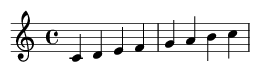
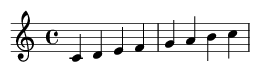

In [6]:
# lets discover something to get the distance between pitches

sc2=returnScale('c')
svg_img=svg_table2(sc2)
display(HTML(svg_img))

In [7]:
greekModes = [ 'ionian','dorian','phrygian',
    'lydian','mixolydian','aeolian',
    'locrian' ]

In [10]:
#c_major_pitches = scale.MajorScale('A3').getPitches()

#for idx in range(7):
#    sc = returnScale(c_major_pitches[idx],greekModes[idx])
#    svg_img = svg_table2(sc)
#    display(HTML(svg_img))


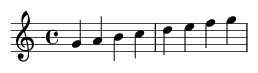
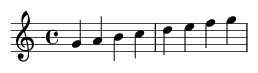

In [12]:
sc = returnScale('g','mixolydian')
svg_img = svg_table2(sc)
display(HTML(svg_img))


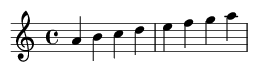
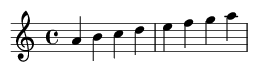

In [14]:
sc = returnScale('a','aeolian')
svg_img = svg_table2(sc)
display(HTML(svg_img))